 #### 분석 목표
 1. 시간대별 평균 발전량 추이 분석 (bar, line)
   - 시간대별 발전량 추이 분석을 통해 가장 발전이 잘되는 시간대 구간 확인
 2. 태양광 발전량과 기상 데이터 각각의 상관관계 분석 (scatter, heatmap)
   - 발전량과 기상 데이터(강수량, 기온, 습도, 일사량, 일조시간, 전운량, 시정, 풍속, 풍향)의 상관 관계 
     분석을 통해 발전량에 영향을 주는 기상 요소를 확인하여 추후 예측 모델에 활용
 3. 월별 합계 발전량, 합계 일조시간, 평균 일사량 추이 분석 (bar, line)
   - 월별 합계 발전량, 합계 일조시간, 평균 일사량, 평균 강수량 추이 분석을 통해 발전 효율이 좋은 월 선정
 4. 태양광 발전량과 연관성이 큰 기상 데이터 조합 케이스별 상관관계 분석(ANOVA)
   - 단일 기상 데이터별 상관계수와 연관성이 큰 기상 데이터 조합 케이스별 상관계수 비교

* DataFrame 형태
  - Column
    - 날짜 : YYYYMMDD  (단위 : 연월일)
    - 시간 : HH  (단위 : 시간)
    - 발전량 : (단위 : Wh)
    - 강수량 : (단위 : mm)
    - 습도 : (단위 : %)
    - 일사량 : (단위 : MJ/m2)
    - 일조시간 : (단위 : hr)
    - 전운량 : (단위 : 10분위)
    - 시정 : (단위 : 10m)
    - 풍속 : (단위 : m/s)
    - 풍향 : (단위 : 16방위)

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime
import scipy.stats as stats

# 경고 무시 코드 추가
import warnings
warnings.filterwarnings('ignore')

# sns.set() 설정값을 리셋해주는 함수
def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list

# sns.set(font_scale=2)

In [204]:
pg_file = '한국전력거래소_지역별 시간별 태양광 발전량_20230228.csv'
pg_data = pd.read_csv(pg_file, encoding='cp949')

# pg_data.head()

# 부산지역, 태양광 발전량 데이터만 추출
# pg_data['지역'].unique()
filter_r = pg_data['지역'] == '부산시'
pg_data = pg_data.iloc[:, :-1][filter_r]

# 2023년 데이터 삭제 처리
filter_y = pg_data['거래일자'].str.contains('2023-')
idx = pg_data[filter_y].index
# print(len(idx))
pg_data.drop(idx, inplace=True)
pg_data = pg_data.replace('부산시', '부산')


# 인덱스 초기화
pg_data = pg_data.reset_index(drop=True)

print(len(pg_data))
pg_data.head()

52584


,거래일자,거래시간,지역,태양광 발전량(MWh)
0,2017-01-01,1,부산,
1,2017-01-01,2,부산,
2,2017-01-01,3,부산,
3,2017-01-01,4,부산,
4,2017-01-01,5,부산,


In [205]:
# 날짜 분리하기
pg_data['거래일자'] = pd.to_datetime(pg_data['거래일자'])

# 24시 데이터를 익일 00시로 변경
filter_t = pg_data['거래시간'] == 24
pg_data['거래일자'][filter_t] = pg_data['거래일자'][filter_t] + datetime.timedelta(days=1)
pg_data['거래시간'][filter_t] = 0

# print(pg_data)

# pg_data.dtypes

pg_data['년'] = pg_data['거래일자'].dt.year
pg_data['월'] = pg_data['거래일자'].dt.month
pg_data['일'] = pg_data['거래일자'].dt.day


filter_d = pg_data['년'] == 2023
pg_data = pg_data.drop(index=pg_data[filter_d].index, axis=0)
# print(pg_data[filter_d])

pg_data = pg_data.iloc[:, 1:]
pg_data.columns = ['시간', '지역', '발전량', '년', '월', '일']
pg_data = pg_data[['지역', '년', '월', '일', '시간', '발전량']]

# pg_data['시간'] = pg_data['시간'].astype(np.int64)-1

pg_data.head()

# print(len(pg_data))

,지역,년,월,일,시간,발전량
0,부산,2017,1,1,1,
1,부산,2017,1,1,2,
2,부산,2017,1,1,3,
3,부산,2017,1,1,4,
4,부산,2017,1,1,5,


In [206]:
# 년도별 기상 데이터 가져오기
for year in range(2017, 2023) :
  globals()['weather_'+str(year)] = f'OBS_ASOS_TIM_{year}.csv'
  globals()['w_data_'+str(year)] = pd.read_csv(globals()['weather_'+str(year)], encoding='cp949')

w_data = pd.concat((w_data_2017, w_data_2018, w_data_2019, w_data_2020, w_data_2021, w_data_2022), axis=0)


w_data = w_data.iloc[:,[1,2,4,5,6,7,12,13,15,16]]

# NaN 처리
w_data = w_data.fillna(0.0)

# 년, 월, 일, 시간 분리
w_data['일시'] = pd.to_datetime(w_data['일시'], format='%Y-%m-%d %H:%M', errors='raise')
w_data['년'] = w_data['일시'].dt.year
w_data['월'] = w_data['일시'].dt.month
w_data['일'] = w_data['일시'].dt.day
w_data['시간'] = w_data['일시'].dt.hour

w_data.columns = ['지역', '일시', '강수량', '풍속', '풍향', '습도', '일조시간', '일사량', '전운량', '시정', '년', '월', '일', '시간']
w_data = w_data[['지역', '년', '월', '일', '시간', '강수량', '풍속', '풍향', '습도', '일조시간', '일사량', '전운량', '시정']]

# print(w_data.dtypes)
print(len(w_data))
w_data.head()

52578


,지역,년,월,일,시간,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
0,부산,2017,1,1,1,0.0,3.6,360.0,67,0.0,0.0,0.0,1438.0
1,부산,2017,1,1,2,0.0,4.0,360.0,67,0.0,0.0,0.0,1572.0
2,부산,2017,1,1,3,0.0,1.5,360.0,69,0.0,0.0,0.0,1407.0
3,부산,2017,1,1,4,0.0,0.4,0.0,67,0.0,0.0,0.0,1392.0
4,부산,2017,1,1,5,0.0,3.3,320.0,68,0.0,0.0,0.0,1335.0


In [207]:
# 길이 오류치 확인 테스트
# df = df.reset_index()
# df1 = df.groupby(['년'])
# df2 = df1.count()
# df2.to_csv('./test.csv', encoding='cp949')

# pg_df1 = pg_df.groupby(['년'])
# pg_df1 = pg_df1.count()
# w_df1 = w_df.groupby(['년'])
# w_df1 = w_df1.count()

# pg_df1.to_csv('./test1.csv', encoding='cp949')
# w_df1.to_csv('./test2.csv', encoding='cp949')

In [208]:
pg_df = pg_data.set_index(['년','월','일','시간','지역'])
w_df = w_data.set_index(['년','월','일','시간','지역'])

print(len(pg_data), len(w_data))

df = pg_df.join(w_df)

# 발전량 공백 제거 및 0으로 처리
df['발전량'] = df['발전량'].str.strip()
df['발전량'].replace('', 0.0, inplace=True)
df['발전량'] = df['발전량'].astype(np.float64)

# print(df['발전량'].unique())

df = df.replace('', 0.0)
df = df.fillna(0.0)

df = df.reset_index()


# 매년 1월 1일 00시 데이터 없는 부분 삭제
filter_nm = df['월'] == 1
filter_nd = df['일'] == 1
filter_nh = df['시간'] == 0
df = df.drop(index=df.loc[(filter_nm & filter_nd & filter_nh)].index, axis=0)


# df.to_csv('./result.csv', encoding='cp949')
df

52583 52578


,년,월,일,시간,지역,발전량,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
0,2017,1,1,1,부산,0.00,0.0,3.6,360.0,67.0,0.0,0.0,0.0,1438.0
1,2017,1,1,2,부산,0.00,0.0,4.0,360.0,67.0,0.0,0.0,0.0,1572.0
2,2017,1,1,3,부산,0.00,0.0,1.5,360.0,69.0,0.0,0.0,0.0,1407.0
3,2017,1,1,4,부산,0.00,0.0,0.4,0.0,67.0,0.0,0.0,0.0,1392.0
4,2017,1,1,5,부산,0.00,0.0,3.3,320.0,68.0,0.0,0.0,0.0,1335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52578,2022,12,31,19,부산,2.48,0.0,2.1,250.0,48.0,0.0,0.0,0.0,4309.0
52579,2022,12,31,20,부산,3.40,0.0,2.9,250.0,51.0,0.0,0.0,0.0,3672.0
52580,2022,12,31,21,부산,2.64,0.0,1.6,200.0,50.0,0.0,0.0,0.0,3800.0
52581,2022,12,31,22,부산,1.05,0.0,2.5,230.0,52.0,0.0,0.0,0.0,3406.0


In [209]:
# 2018년 7월20일~9월15일 데이터 누락으로 인한 평균값 대체 처리
rp_df = df
rp_df = rp_df.drop(['지역'], axis=1)

rp_m = rp_df.groupby(['월'])
rp_mean = rp_m.mean()


replace_insolation = rp_mean.iloc[6:9,9]

replace_insolation

월
7    0.709422
8    0.607858
9    0.529225
Name: 일사량, dtype: float64

Text(0.5, 1.0, 'fairplot')

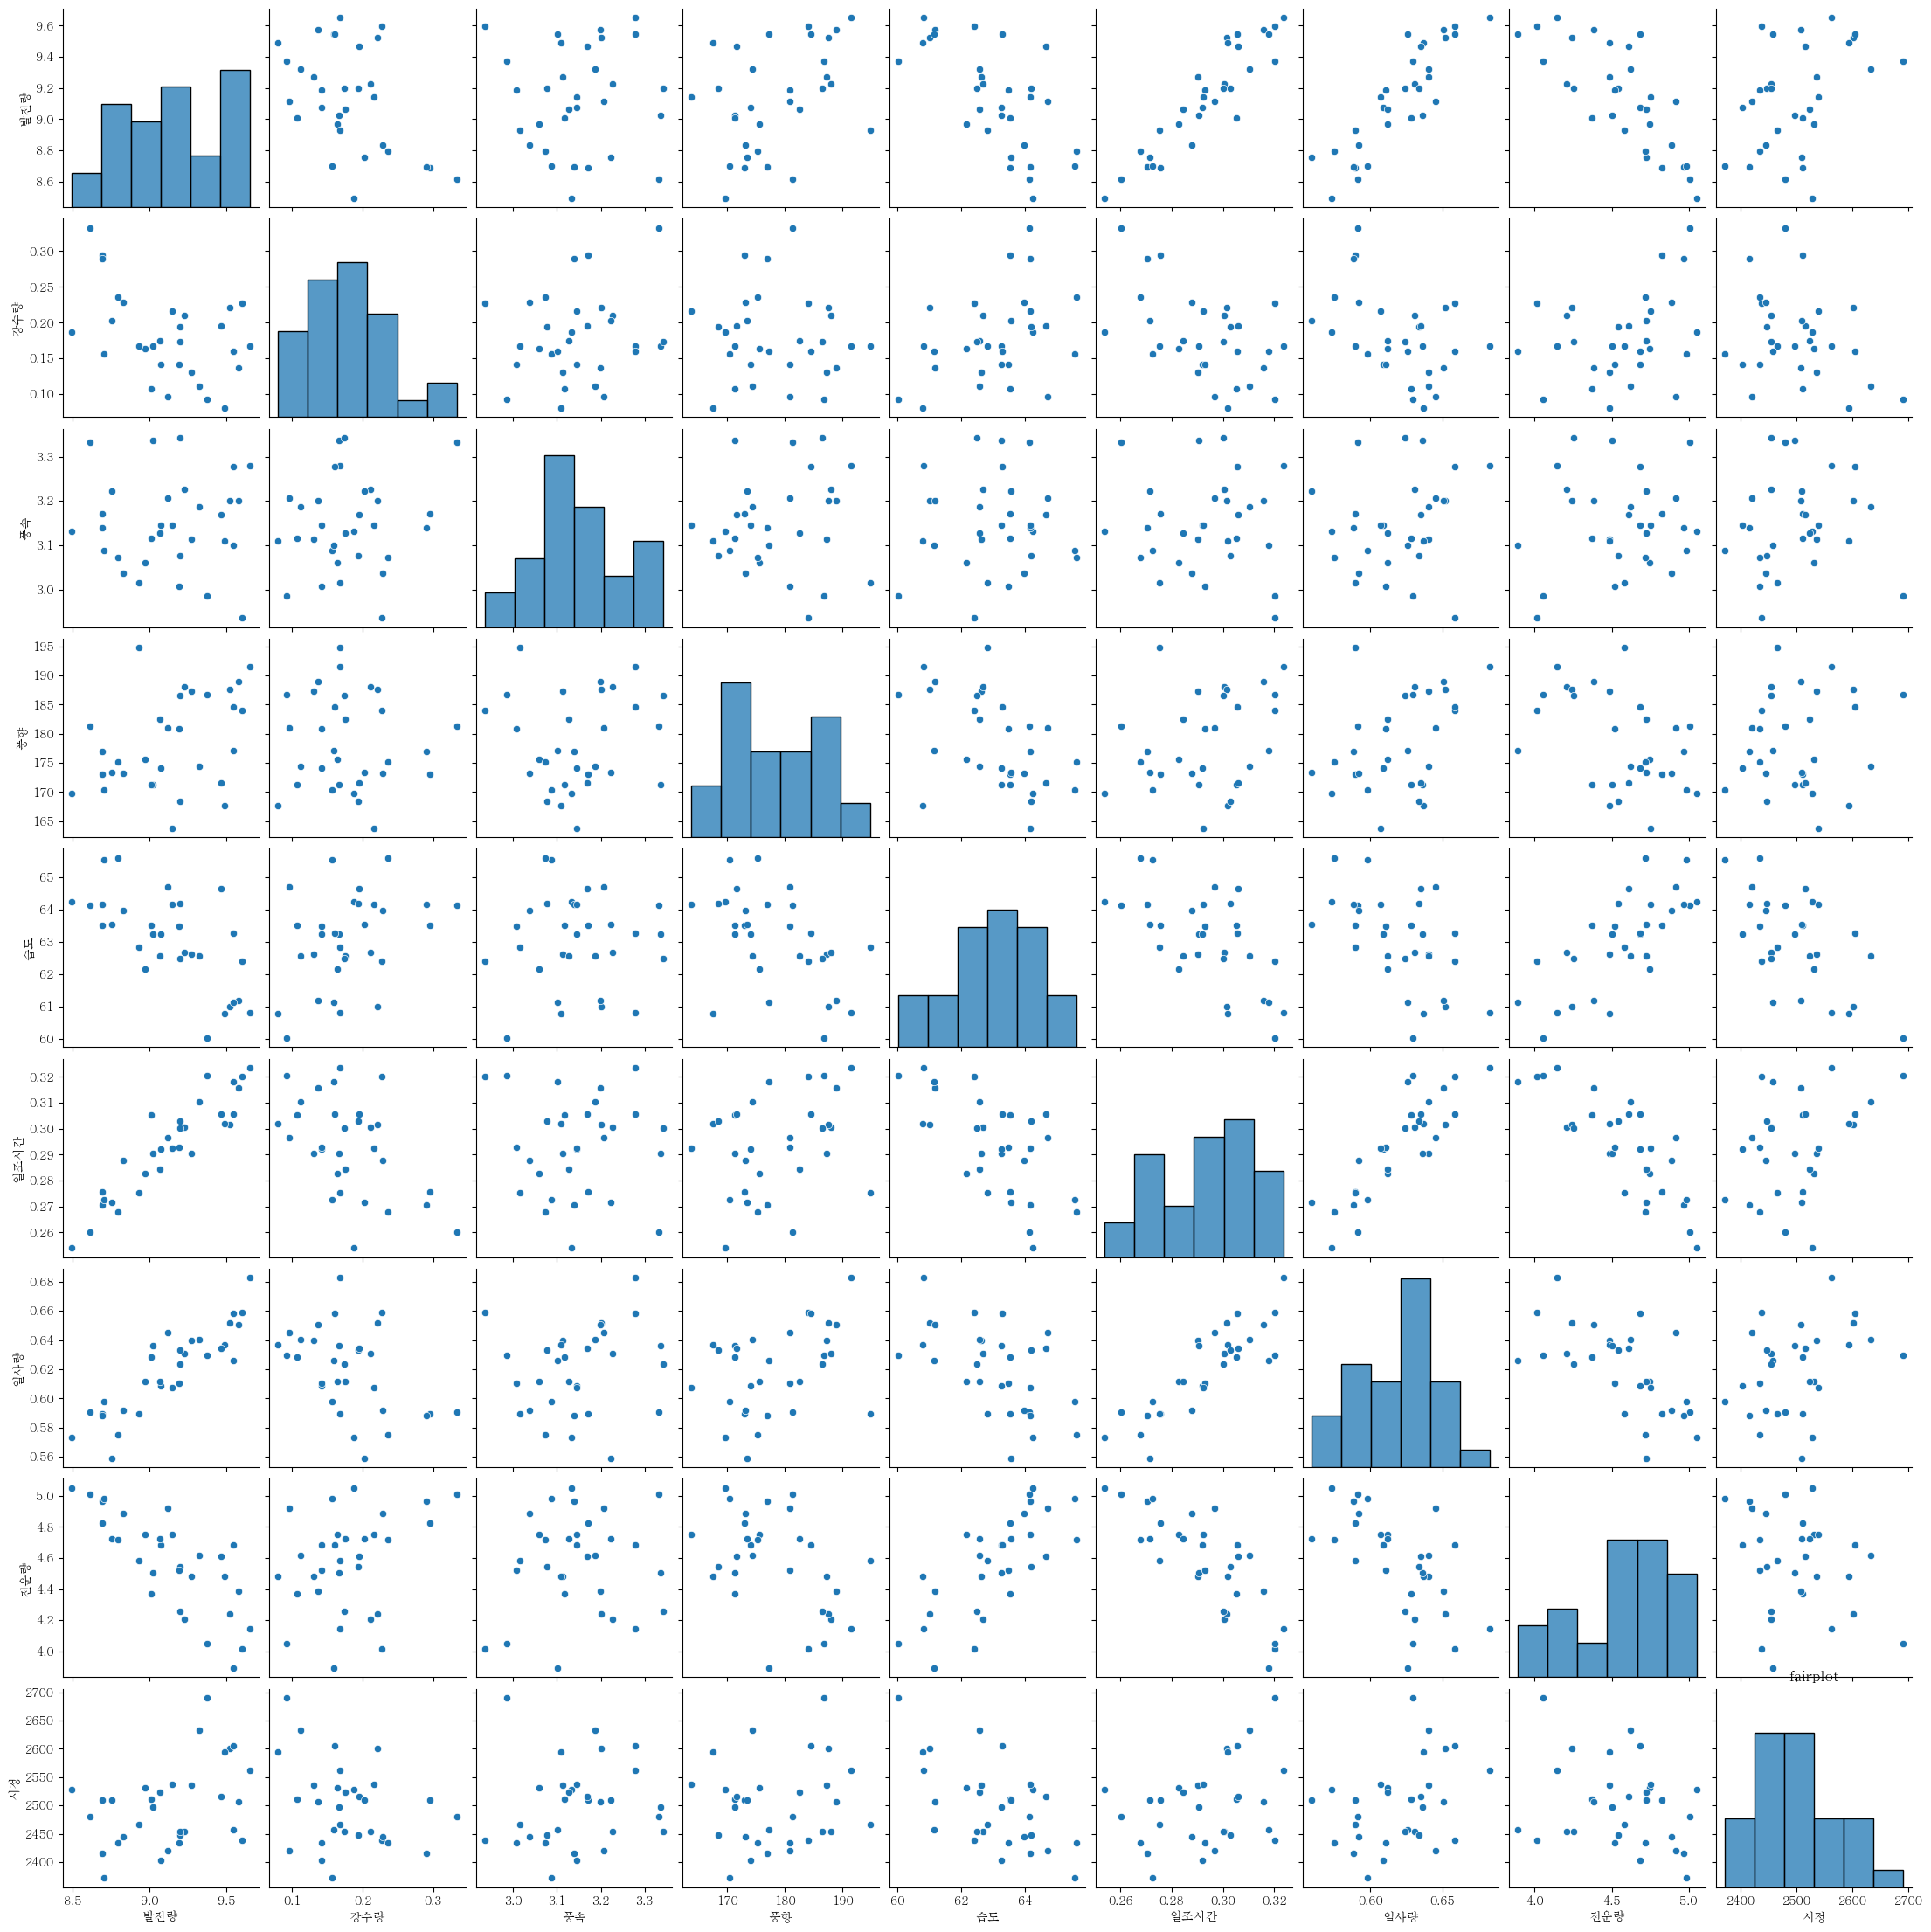

In [210]:
# 데이터 탐색(EDA)

df0 = df
df0 = df0.drop(['지역'], axis=1)

g0 = df0.groupby('일')
gr0 = g0.mean()

gr0 = gr0.iloc[:,3:]

sns.pairplot(gr0)
plt.title('fairplot')

데이터 탐색(EDA)

pairplot 적용 결과
- 발전량과 강한 상관관계를 갖는 3가지 요소 확인 
  * 양의 상관관계 : 일사량, 일조시간
  * 음의 상관관계 : 전운량

In [211]:
# 데이터 탐색(EDA)
df.iloc[:, 5:].describe()

,발전량,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
count,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000
mean,9.127404,0.180636,3.148956,178.367378,63.080433,0.292870,0.619586,4.574004,2497.517060
std,12.927962,1.580124,1.761747,109.719131,20.772051,0.426507,0.945090,4.063480,1501.245413
min,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,70.000000,47.000000,0.000000,0.000000,0.000000,1599.000000
50%,2.090000,0.000000,2.900000,200.000000,64.000000,0.000000,0.000000,5.000000,2000.000000
75%,15.540000,0.000000,4.000000,270.000000,79.000000,0.800000,1.060000,9.000000,3800.750000
max,58.670000,78.800000,18.100000,360.000000,100.000000,1.000000,4.770000,10.000000,5000.000000


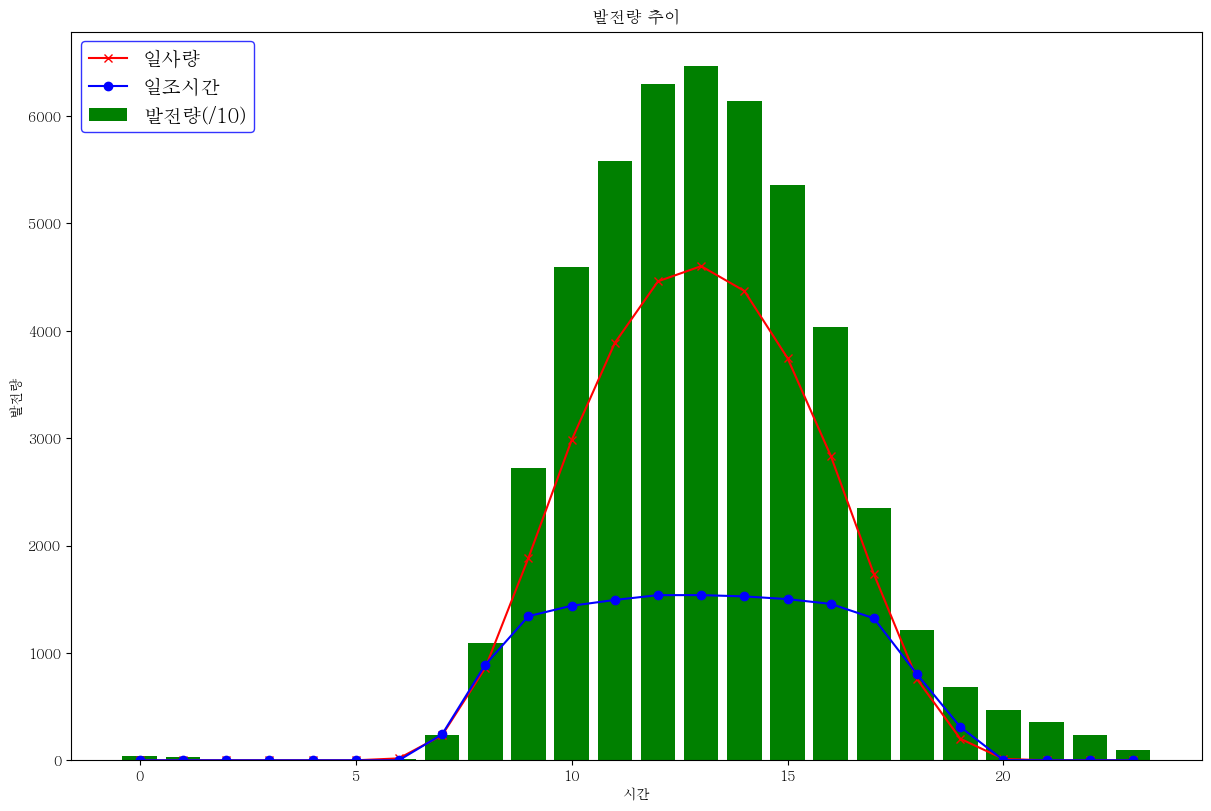

In [212]:
# 시간대별 평균 발전량 추이 분석 (bar, line)

g1 = df.groupby('시간')

gr1 = g1.sum()

fig, axe = plt.subplots(figsize=(12, 8), layout='constrained')
# fig.suptitle('시간대별 추이')

axe.set_title('발전량 추이')
axe.set_xlabel("시간")
axe.set_ylabel("발전량")

axe.bar(gr1.index, gr1['발전량']/10, color='g', label='발전량(/10)')
axe.plot(gr1.index, gr1['일사량'], color='r', marker='x', label='일사량')
axe.plot(gr1.index, gr1['일조시간'], color='b', marker='o', label='일조시간')

prop = dict(
  # family='fantasy', # 글씨체
  # style='italic', # 글씨 형식 - 이탤릭형식
  size=14 # 글씨 크기
)

config_legend = dict(
  loc = 'upper left',
  prop=prop,
  edgecolor='b'
)

axe.legend(**config_legend)
# axe.legend(['발전량', '일사량', '일조시간'], loc='upper left')  # 임의 지정 시 자리가 맞지 않는 경우 발생

# sns.relplot(data=g2, x='시간', y='발전량', kind='line')

52578


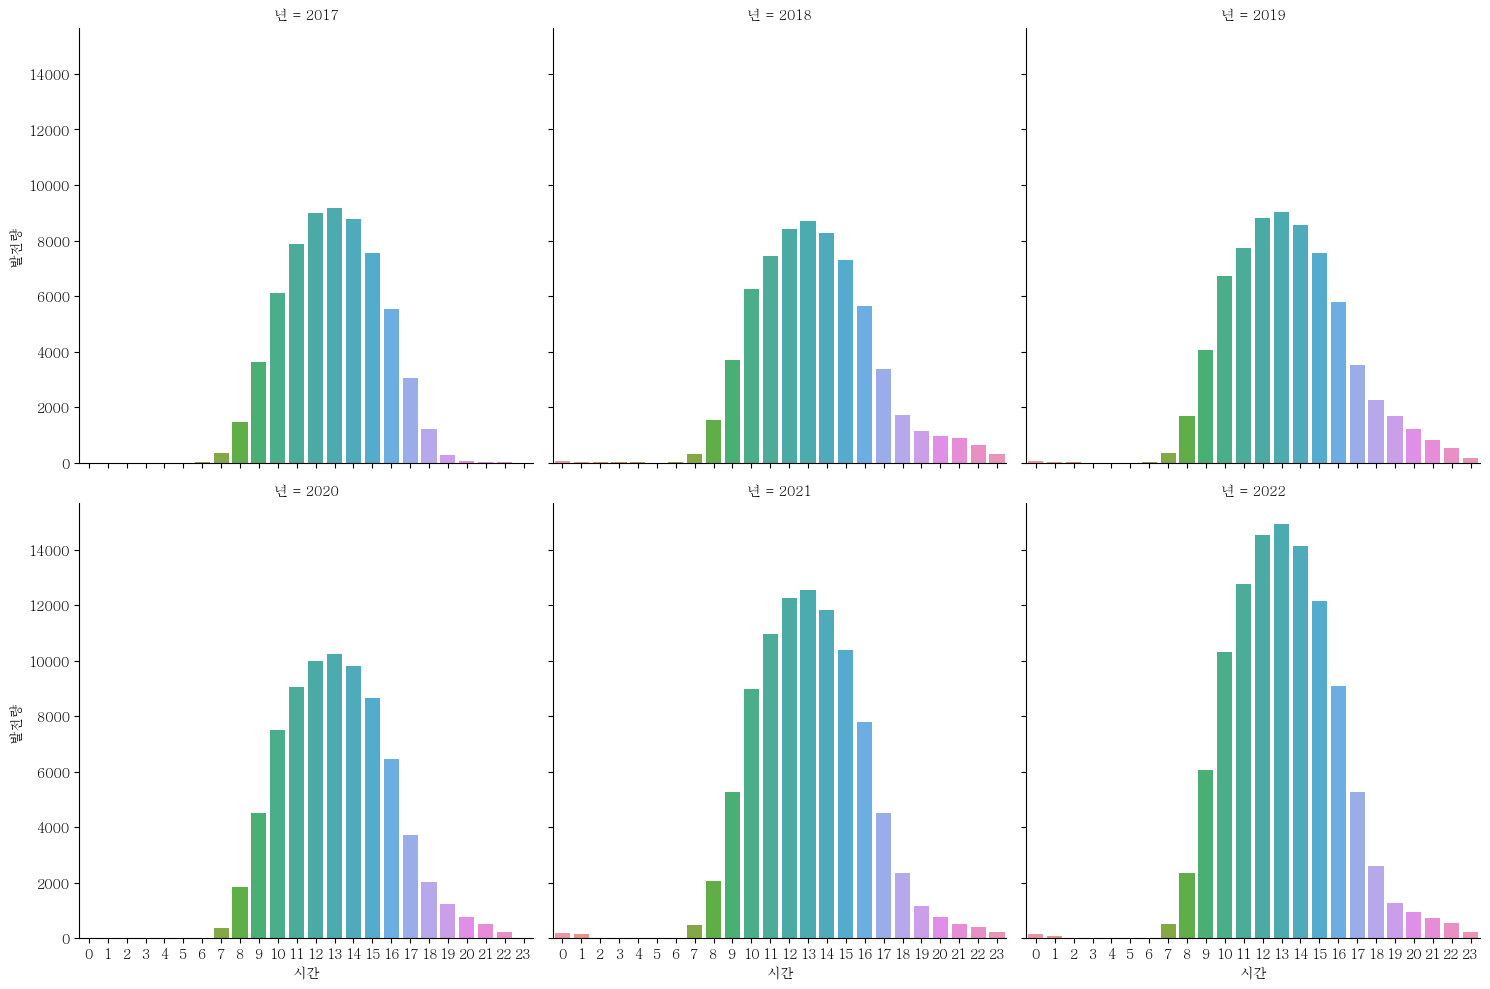

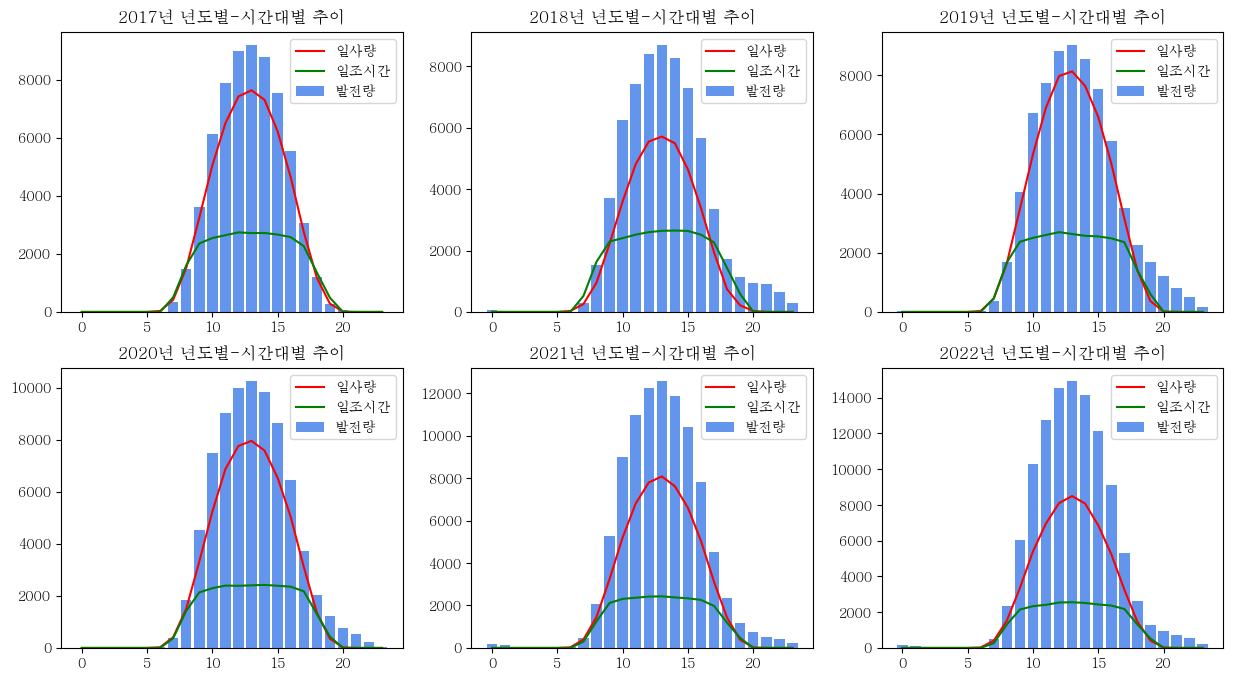

In [228]:
# 년도별 시간대별 발전량 추이 분석

df_p = df
df_p = df_p.drop(['지역'], axis=1)
print(len(df_p))

g_p = df_p.groupby(['년', '시간'])

gr_p = g_p.sum()

gr_p.reset_index(inplace=True)


sns.catplot(data=gr_p, x='시간', y='발전량', col='년', kind='bar', col_wrap=3)

gr_p

years = [2017, 2018, 2019, 2020, 2021, 2022]

def y_filter(year) :
  y_filter = gr_p['년'] == year
  return y_filter

fig, axes = plt.subplots(2, 3, figsize=(15,8))

for i in range(6) :
  axes[i//3][i%3].set_title(f"{years[i]}년 년도별-시간대별 추이")
  axes[i//3][i%3].tick_params(labelsize=10)
  axes[i//3][i%3].bar(gr_p['시간'].unique(), gr_p['발전량'][y_filter(years[i])], color='cornflowerblue')
  axes[i//3][i%3].plot(gr_p['시간'].unique(), gr_p['일사량'][y_filter(years[i])]*10, color='red')
  axes[i//3][i%3].plot(gr_p['시간'].unique(), gr_p['일조시간'][y_filter(years[i])]*10, color='green')
  axes[i//3][i%3].legend(['일사량', '일조시간', '발전량'])

     1. 시간대별 평균 발전량 추이 분석 (bar, line)
       - 시간대별 발전량 추이 분석을 통해 가장 발전이 잘되는 시간대 구간 확인
  
    -> 발전량이 가장 높은 시간대 : 13시
        통상(12~14시) 태양이 최대 고도에 이른 시간대에 높은 발전량 수치가 나타남

    -> 년도별로 나누어 시간대별 평균 발전량 추이를 분석한 결과 발전량이 높은 시간대가 동일하게 나타나는 것을 볼 수 있음

    -> 20시 이후 데이터의 경우 추가 확인 필요 (일사량이 전혀 없는 시간대 데이터 존재)

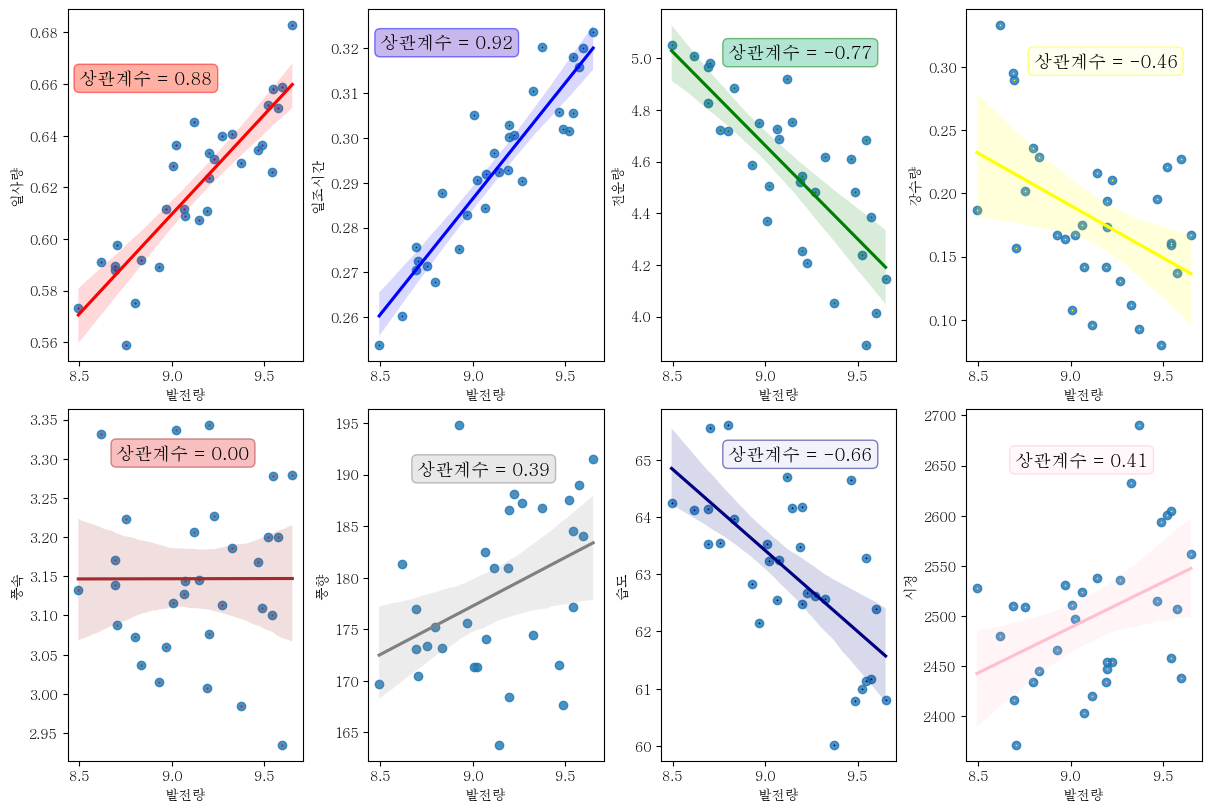

In [214]:
# 2. 태양광 발전량과 기상 데이터 각각의 상관관계 분석 (scatter, heatmap)
df3 = df
df3 = df3.drop(['지역'], axis=1)

g3 = df3.groupby('일')
g3 = g3.mean()


g3 = g3.iloc[:,3:].reset_index(drop=True)

# 상관계수 구하기
df_corr = g3.corr()

fig, axes = plt.subplots(2,4, figsize=(12,8), layout='constrained')
def Box_Style(c_num) :
  color=['tomato', 'mediumpurple', 'mediumaquamarine', 'lightyellow', 'lightcoral', 'lightgrey', 'lavender', 'lavenderblush']
  edge_color=['red', 'blue', 'green', 'yellow', 'brown', 'grey', 'navy', 'pink']
  box_style={'facecolor': color[c_num], 'edgecolor':edge_color[c_num],'boxstyle':'round','alpha':0.5}
  return box_style
font_style={'weight': 'bold', 'size':13}

axes[0][0].plot('발전량', '일사량', data=g3, linestyle='none', marker='o', markersize=0.5, color='purple')
sns.regplot(x=g3['발전량'], y=g3['일사량'], fit_reg=True, line_kws={'color':'red'}, ax=axes[0][0])

axes[0][1].plot('발전량', '일조시간', data=g3, linestyle='none', marker='*', markersize=0.5, color='blue')
sns.regplot(x=g3['발전량'], y=g3['일조시간'], fit_reg=True, line_kws={'color':'blue'}, ax=axes[0][1])

axes[0][2].plot('발전량', '전운량', data=g3, linestyle='none', marker='v', markersize=0.5, color='green')
sns.regplot(x=g3['발전량'], y=g3['전운량'], fit_reg=True, line_kws={'color':'green'}, ax=axes[0][2])

axes[0][3].plot('발전량', '강수량', data=g3, linestyle='none', marker='x', markersize=0.5, color='yellow')
sns.regplot(x=g3['발전량'], y=g3['강수량'], fit_reg=True, line_kws={'color':'yellow'}, ax=axes[0][3])

axes[1][0].plot('발전량', '풍속', data=g3, linestyle='none', marker='o', markersize=0.5, color='brown')
sns.regplot(x=g3['발전량'], y=g3['풍속'], fit_reg=True, line_kws={'color':'brown'}, ax=axes[1][0])

axes[1][1].plot('발전량', '풍향', data=g3, linestyle='none', marker='*', markersize=0.5, color='grey')
sns.regplot(x=g3['발전량'], y=g3['풍향'], fit_reg=True, line_kws={'color':'grey'}, ax=axes[1][1])

axes[1][2].plot('발전량', '습도', data=g3, linestyle='none', marker='v', markersize=0.5, color='navy')
sns.regplot(x=g3['발전량'], y=g3['습도'], fit_reg=True, line_kws={'color':'navy'}, ax=axes[1][2])

axes[1][3].plot('발전량', '시정', data=g3, linestyle='none', marker='x', markersize=0.5, color='pink')
sns.regplot(x=g3['발전량'], y=g3['시정'], fit_reg=True, line_kws={'color':'pink'}, ax=axes[1][3])

# figure별 상관계수 적용
cnt = 0
cd = [(8.5,0.66), (8.5,0.32), (8.8, 5), (8.8, 0.3), (8.7, 3.3), (8.7,190), (8.8, 65), (8.7, 2650)]
corr_num = [6,5,7,1,2,3,4,8]
for i in range(2) :
  for j in range(4) :
    axes[i][j].text(cd[cnt][0], cd[cnt][1], f"상관계수 = {df_corr.iloc[0,corr_num[cnt]]:.2f}", color='k', fontdict=font_style, bbox=Box_Style(cnt))
    cnt+=1

<Axes: >

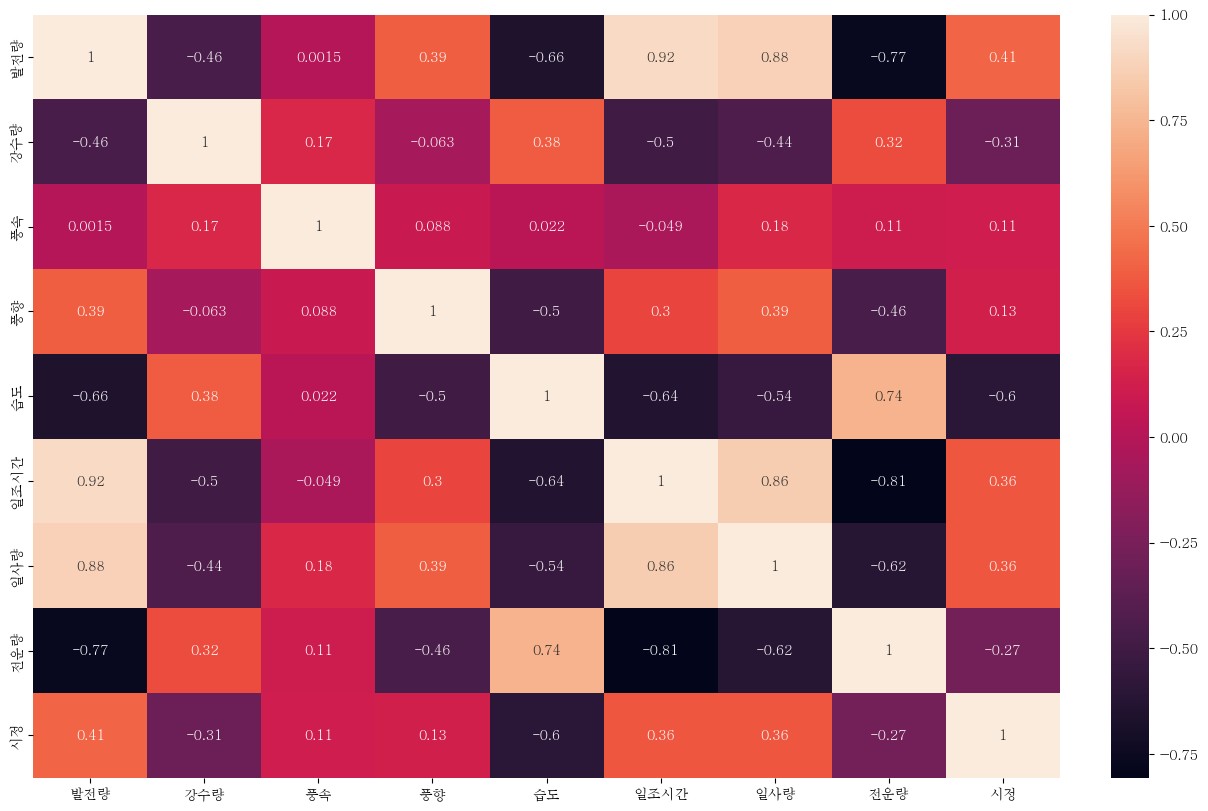

In [215]:
df4 = df
df4 = df4.drop(['지역'], axis=1)

g4 = df4.groupby('일')
g4 = g4.mean()

g4 = g4.iloc[:,3:].reset_index(drop=True)

fig = plt.subplots(figsize=(12,8), layout='constrained') 
sns.heatmap(g4.corr(), linecolor='white', annot=True)

0.06821616301891364 -0.003050888374593219


Text(0.5, 1.0, '발전량-일사량 추이')

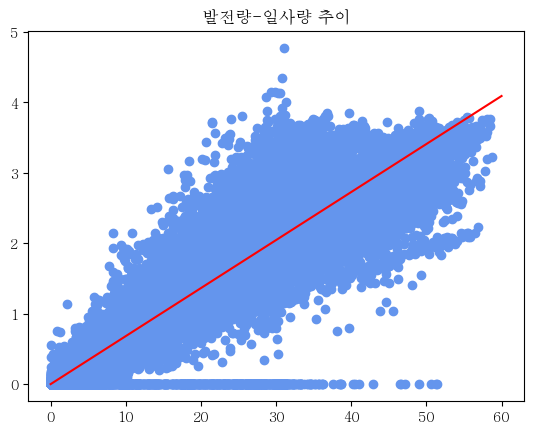

In [238]:
# 발전량, 일사량 추이, 패턴 분석

# y = ax + b
# a = (x와 y의 상관관계 계수) * (y std_dev / x std_dev)
# b = mean_y - (a * mean_x)

# x와 y의 상관관계 계수
xs = df4['발전량']
ys = df4['일사량']
corr = np.corrcoef(xs, ys)[0,1]

std_x = np.std(xs)
std_y = np.std(ys)
mean_x = np.mean(xs)
mean_y = np.mean(ys)
# print(std_x, std_y, mean_x, mean_y)

a = corr * (std_y/std_x)
b = mean_y - (a*mean_x)
print(a,b)

_, axe = plt.subplots()
axe.scatter(xs,ys, color='cornflowerblue')

# 회귀선
# y = 0.81x - 0.62 식을 그린 것!
axe.plot(np.linspace(0, 60, 100), a*np.linspace(0, 60, 100)+b, color='red')

axe.set_title('발전량-일사량 추이')
# df4

     2. 태양광 발전량과 기상 데이터 각각의 상관관계 분석 (scatter, heatmap)
       - 발전량과 기상 데이터(강수량, 습도, 일사량, 일조시간, 전운량, 시정, 풍속,
         풍향)의 상관 관계 분석을 통해 발전량에 영향을 주는 기상 요소를 확인하여 추후 예측 모델에 활용

     -> 상관계수의 절댓값 TOP4 : 일조시간, 일사량, 전운량, 습도
     
     -> 발전량과 일조시간, 일사량, 전운량, 습도의 상관 관계가 있음을 확인할 수 있다.

     고찰
     * 상관관계 분석을 통해 상대습도와 일사량, 일조시간의 반비례 관계을 확인할 수 있었다.
       실제로 연구 논문에서도 해당 관계성을 나타내고 있음을 알 수 있다.(https://koreascience.kr/article/JAKO201413742065313.pdf)
     * 운량과 일사량, 일조시간과의 관계도 또한 유사 논문 사례와 비슷하게 관계성을 가지고 있음을 알 수 있다.
       (https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO201217034923560&oCn=JAKO201217034923560&dbt=JAKO&journal=NJOU00291881) 

,년,발전량
0,2017,64118.06
1,2018,66673.46
2,2019,70460.58
3,2020,77018.40
4,2021,92963.88
5,2022,108666.25


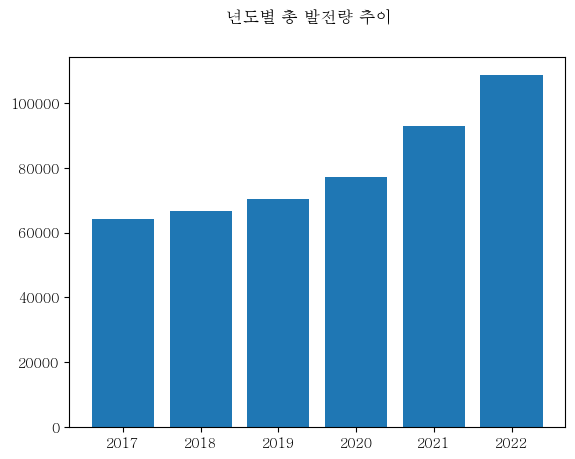

In [225]:
# 비율을 통한 년도별 월별 발전량 추이 도출을 위한 년도별 총 발전량 산출
df_t = df.drop(['지역'], axis=1)

g_t = df_t.groupby('년')
gr_t = g_t.sum()

gr_t.reset_index(inplace=True)
gt = gr_t[['년','발전량']]

fig, axe = plt.subplots()
fig.suptitle("년도별 총 발전량 추이")
axe.bar(gt['년'], gt['발전량'])

gt

      년        발전량
0  2017   64118.06
1  2018   66673.46
2  2019   70460.58
3  2020   77018.40
4  2021   92963.88
5  2022  108666.25


Text(0.5, 1.0, '년도별 월별 발전비율 추이')

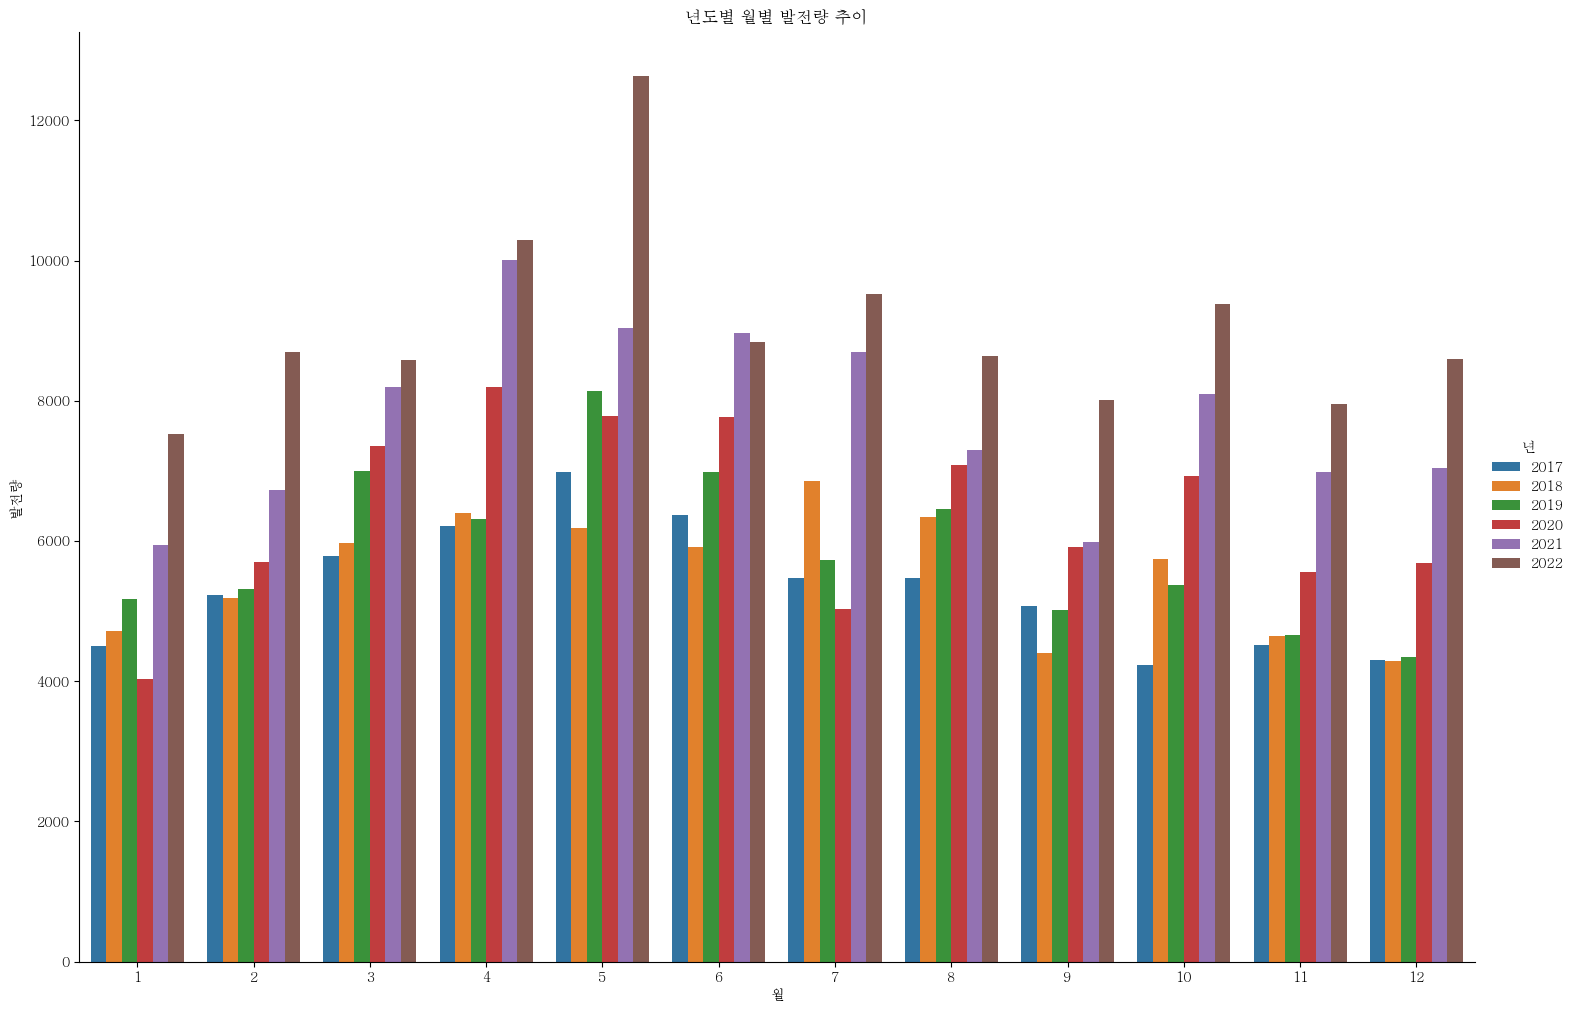

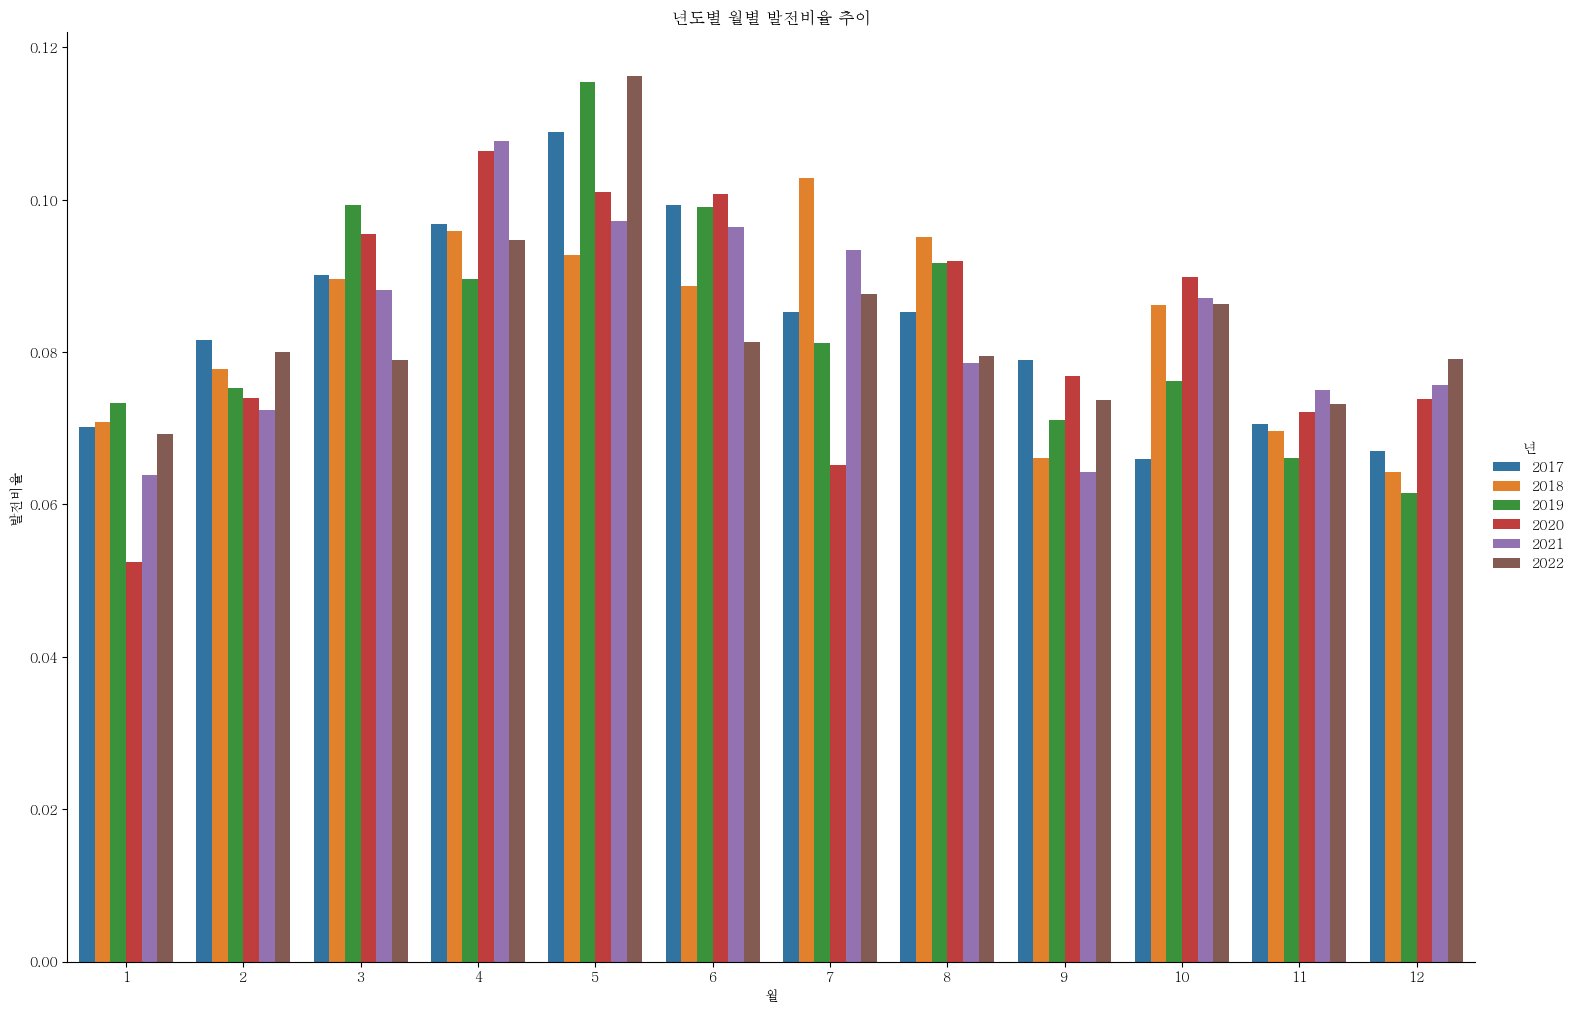

In [226]:
# 년도별 월별 발전량 추이 비교
df6 = df
df6 = df6.drop(['지역'], axis=1)


g6 = df6.groupby(['년', '월'])
g6 = g6.sum()

gr6 = g6.iloc[:,2:]

gr6= gr6.reset_index()

gg6 = sns.catplot(data=gr6, x='월', y='발전량', hue='년', kind='bar', height=10, aspect=1.5)
plt.title('년도별 월별 발전량 추이')

print(gt)

gr6['총발전량']=gr6['년']

# apply로 조건별 데이터 적용 실패
# def total_pg(year) :
#   return gt['발전량'][gt['년']==year][year-2017]

# gr6['총발전량'].apply(total_pg)



# 위와 동일하게 에러 발생
# gr6['총발전량'].apply(lambda x : gt['발전량'][gt['년']==x][x-2017])



# 테스트 결과 - 적용 가능
# x = gt['발전량'][gt['년']==2017][0]
# gr6[gr6['년']==2017]['총발전량'] = xd


years = [2017, 2018, 2019, 2020, 2021, 2022]
for year in years :
  gr6['총발전량'].replace(year, gt['발전량'][gt['년']==int(year)][year-2017], inplace=True)

gr6['발전비율'] = gr6['발전량']/gr6['총발전량']

gr6

gg7 = sns.catplot(data=gr6, x='월', y='발전비율', hue='년', kind='bar', height=10, aspect=1.5)
plt.title('년도별 월별 발전비율 추이')

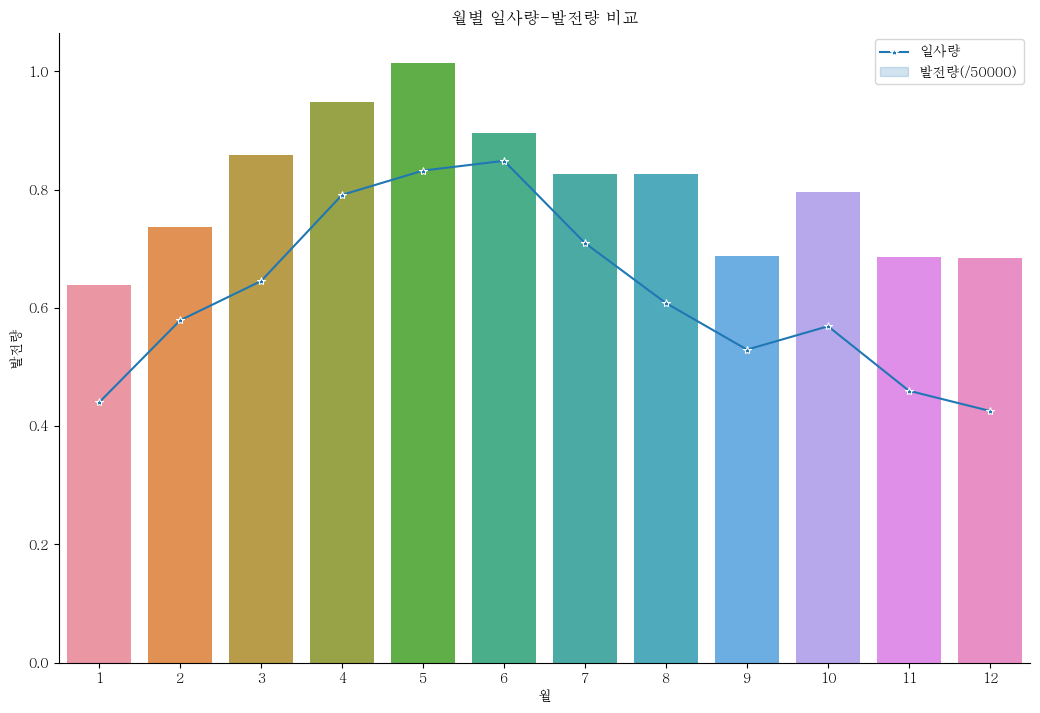

In [217]:
# 3. 월별 합계 발전량, 합계 일조시간, 평균 일사량 추이 분석 (bar, line)
df2 = df
df2 = df2.drop(['지역'], axis=1)

g2 = df2.groupby('월')

# gr2 = g2.agg(['sum', 'mean'])
gr2 = g2.mean()
gr3 = g2.sum()

gr2 = gr2.iloc[:, 3:]
gr3 = gr3.iloc[:, 3:]

# print(gr2.columns)


# sns.relplot(data=gr2, kind='line')
p = sns.relplot(data=gr2, x=gr2.index-1, y='일사량', kind='line', marker='*', height=7, aspect=1.5) 
p = sns.barplot(data=gr3/50000, x=gr3.index, y='발전량')

plt.title('월별 일사량-발전량 비교')


# relplot 대신 lineplot 적용 시
# p = sns.lineplot(data=gr2, x=gr2.index-1, y='일사량')
# sns.barplot(data=gr2, x=gr2.index, y='발전량')
# p.set_title('월별 일사량-발전량 비교')


p.legend(labels = ['일사량', '발전량(/50000)'], loc='upper right')

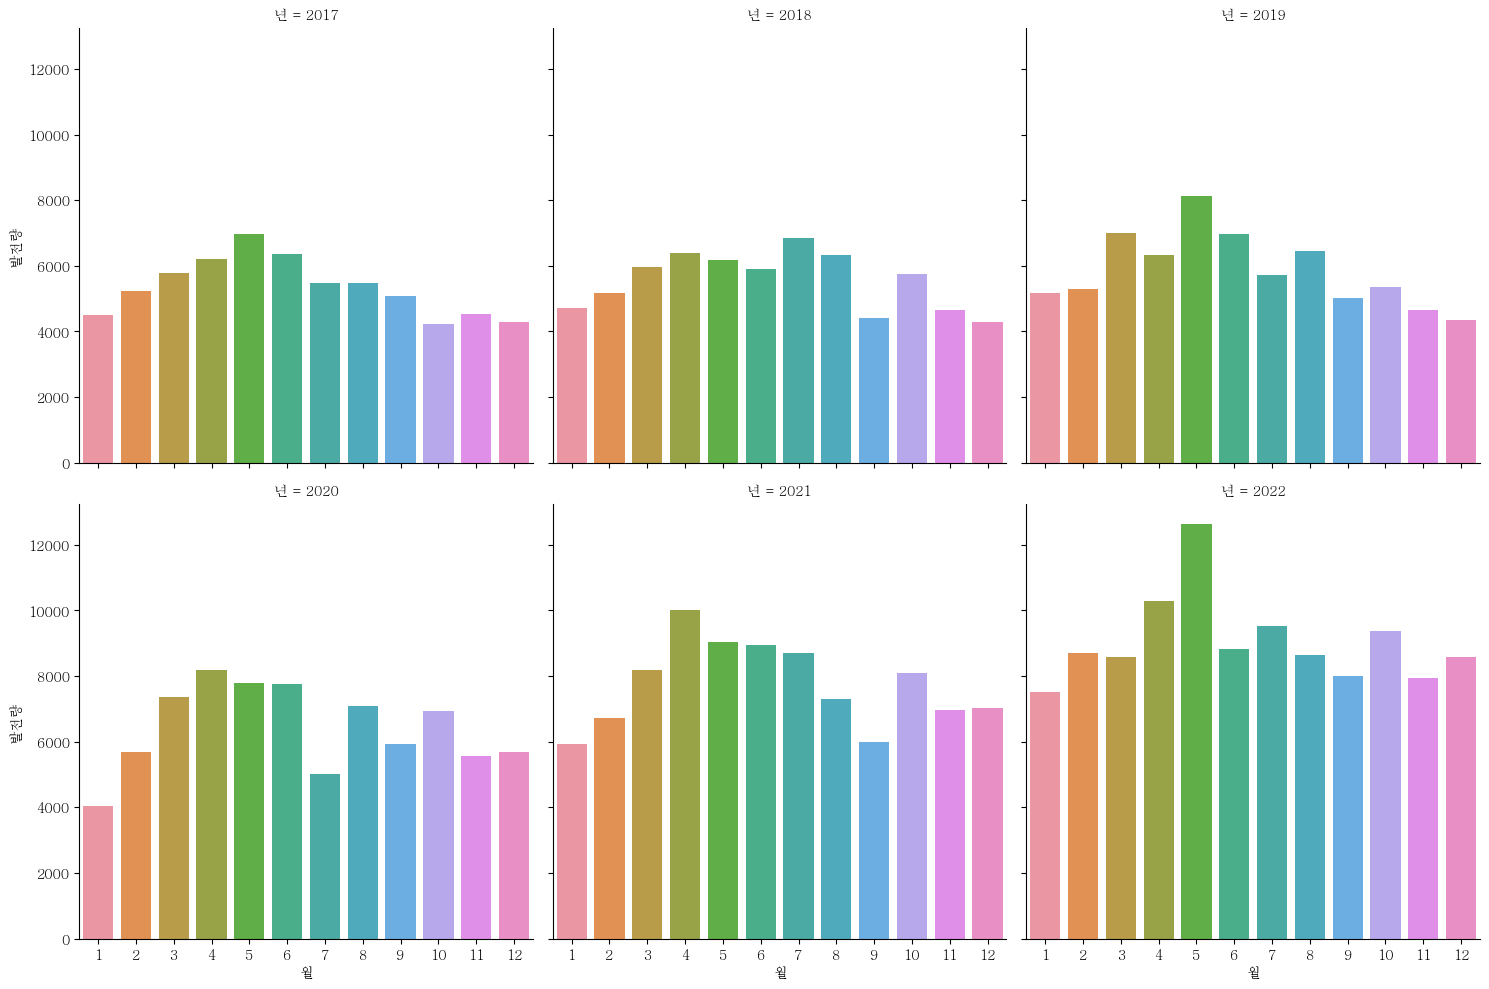

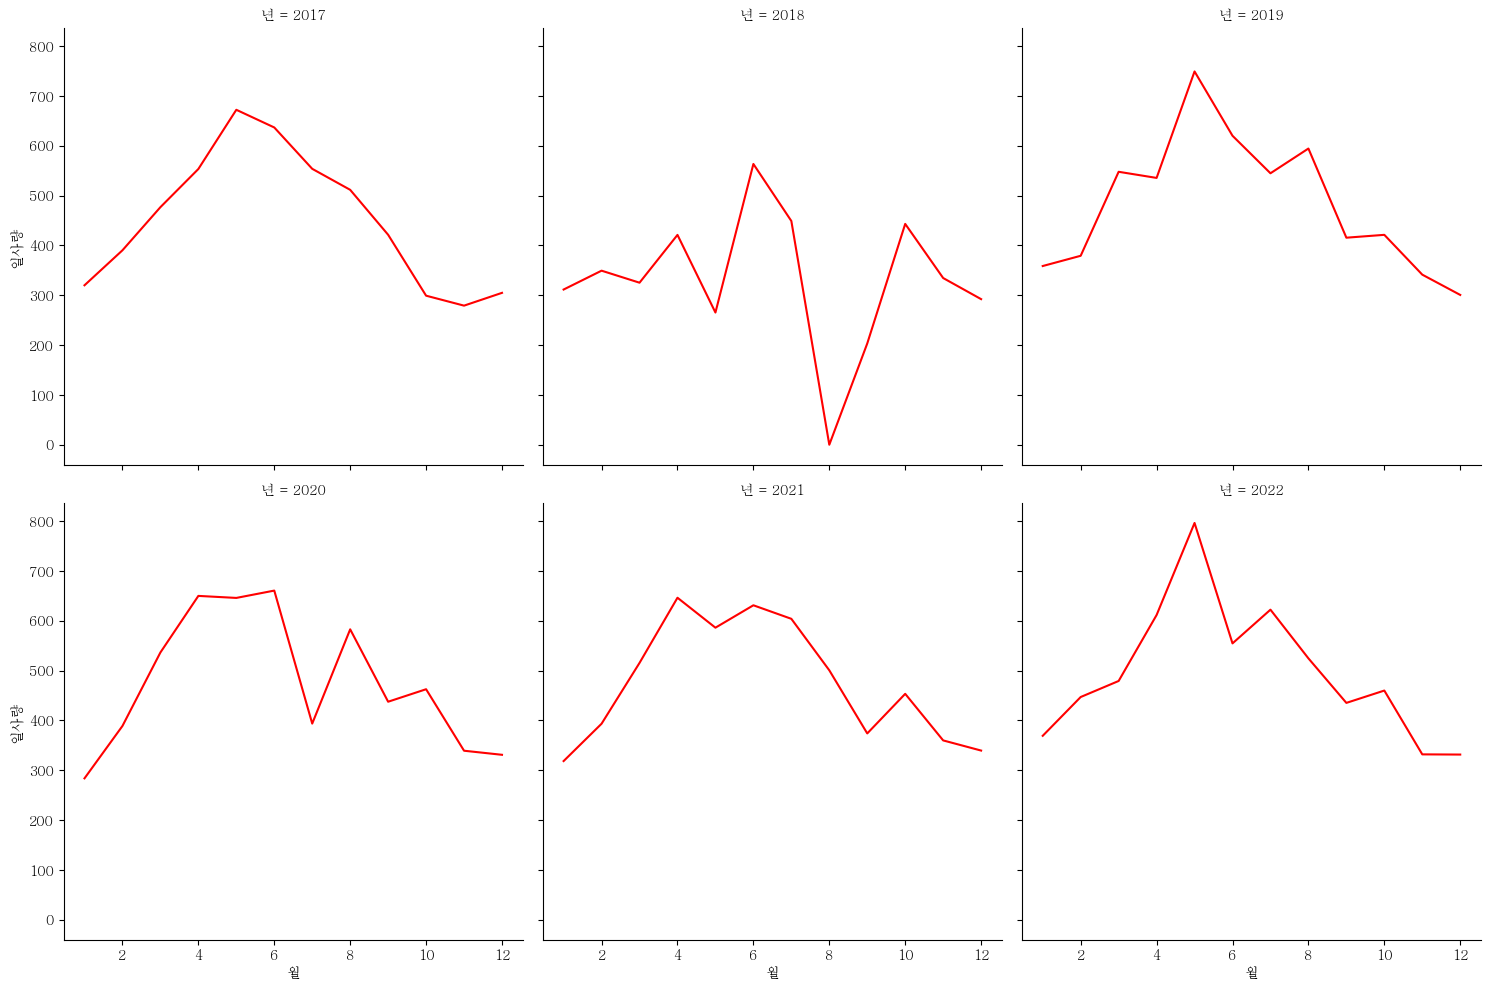

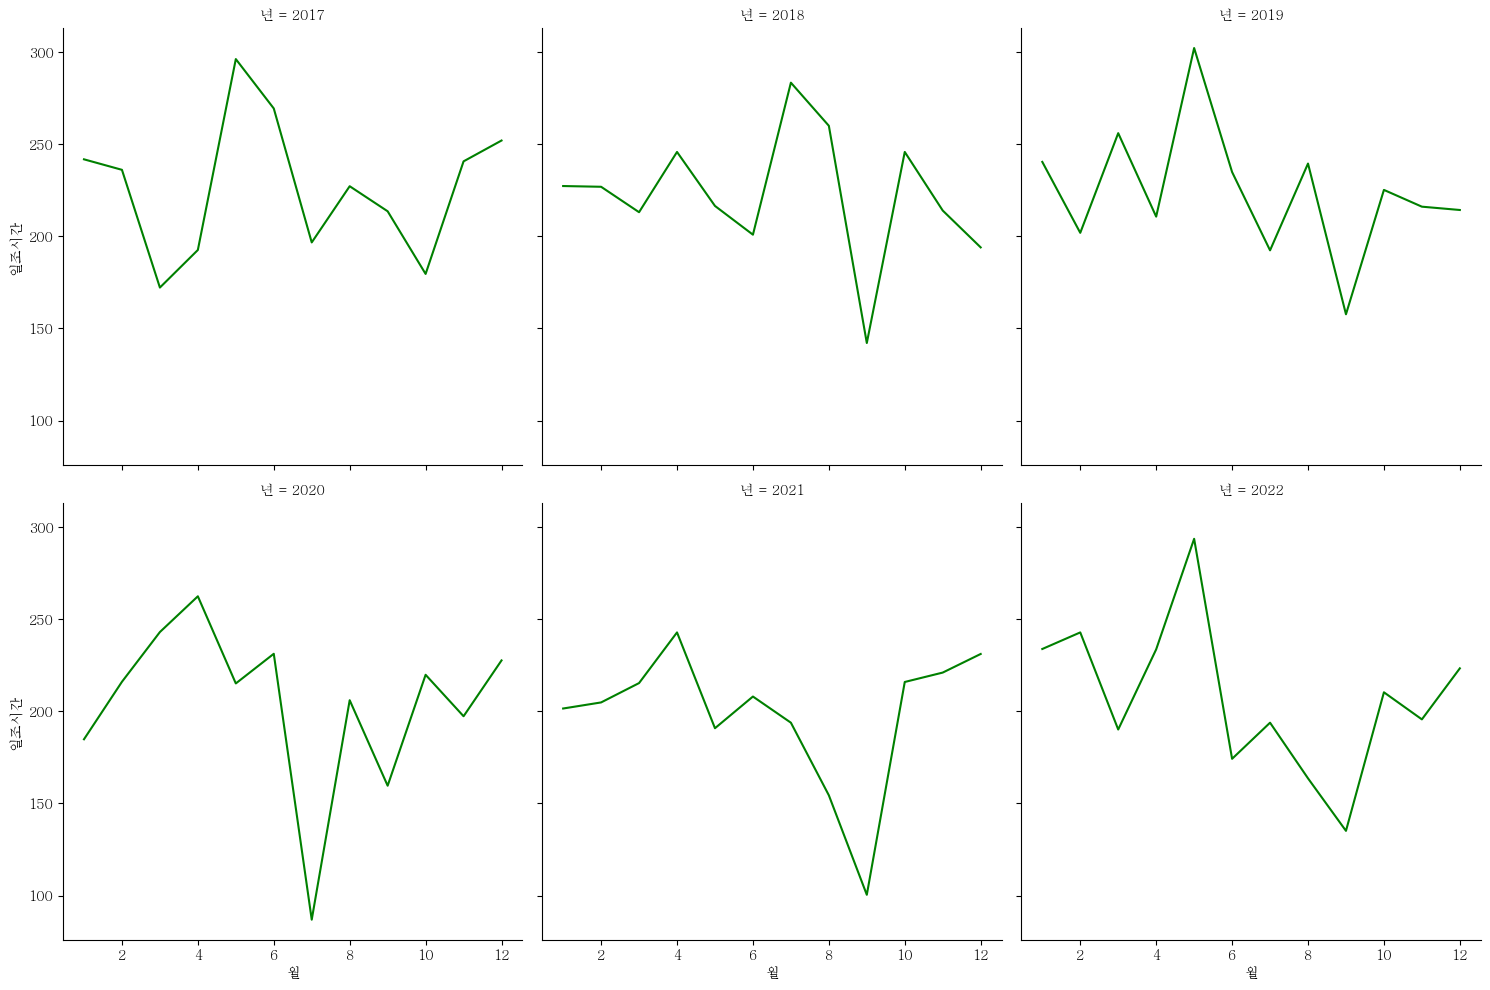

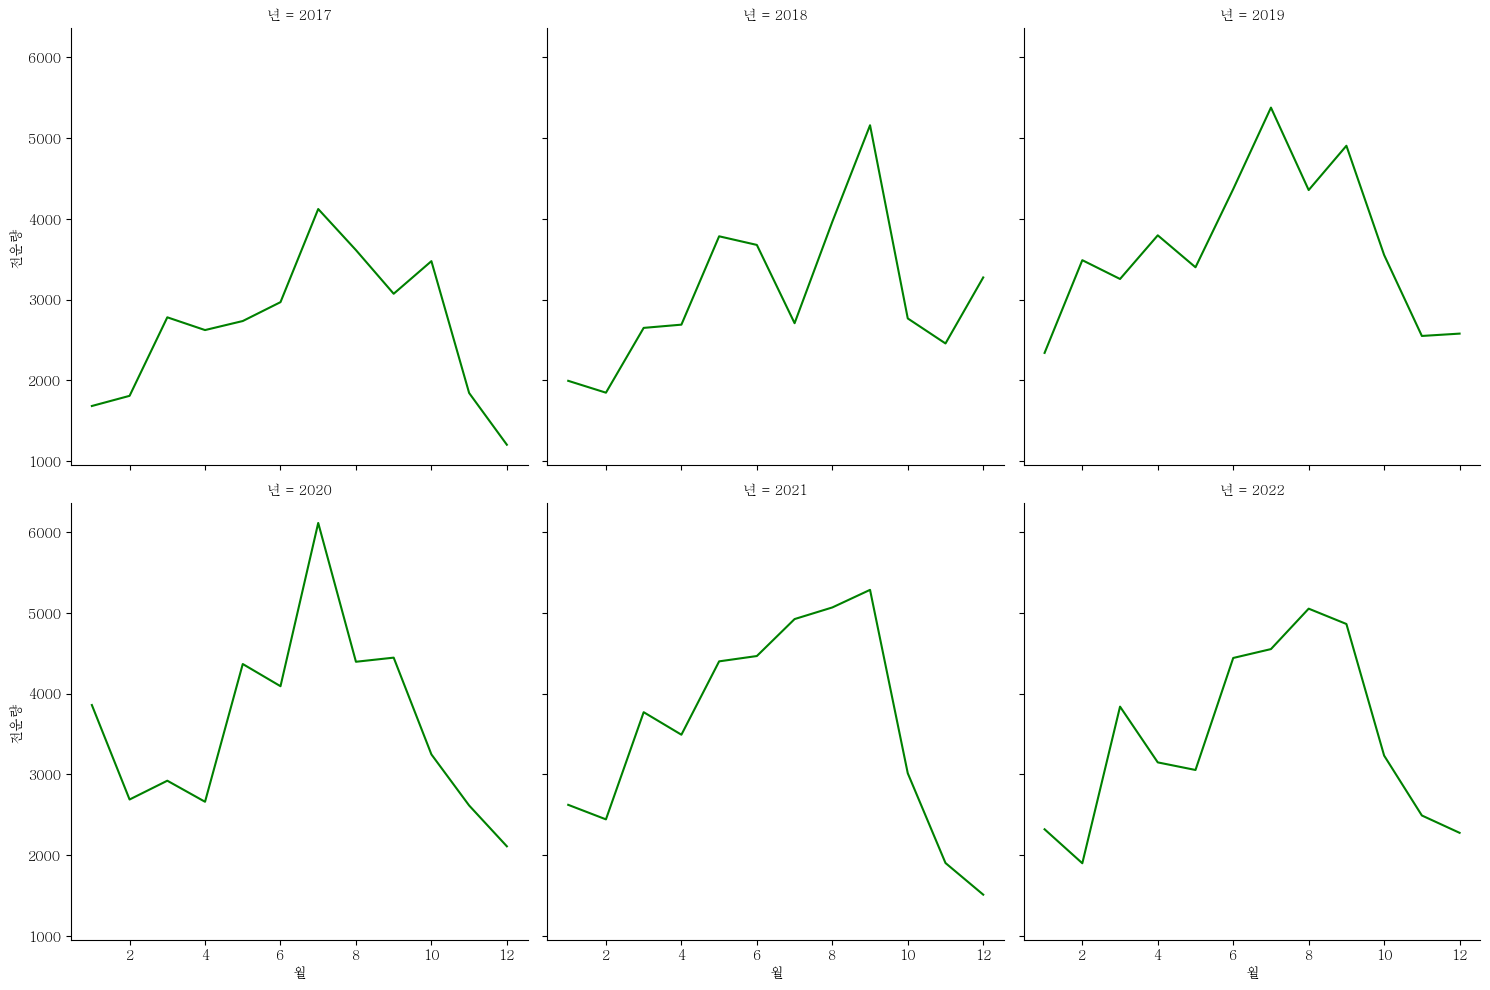

In [218]:
# 년도별 월별 발전량 추이 비교
df5 = df
df5 = df5.drop(['지역'], axis=1)


g5 = df5.groupby(['년', '월'])
g5 = g5.sum()

gr5 = g5.iloc[:,2:]

gr5= gr5.reset_index()

sns.catplot(data=gr5, x='월', y='발전량', col='년', kind='bar', col_wrap=3)
sns.relplot(data=gr5, x='월', y='일사량', col='년', kind='line', col_wrap=3, color='red') 
sns.relplot(data=gr5, x='월', y='일조시간', col='년', kind='line', col_wrap=3, color='green') 
sns.relplot(data=gr5, x='월', y='전운량', col='년', kind='line', col_wrap=3, color='green') 

# sns.set(rc = {'figure.figsize':(15,12)})

# gr5

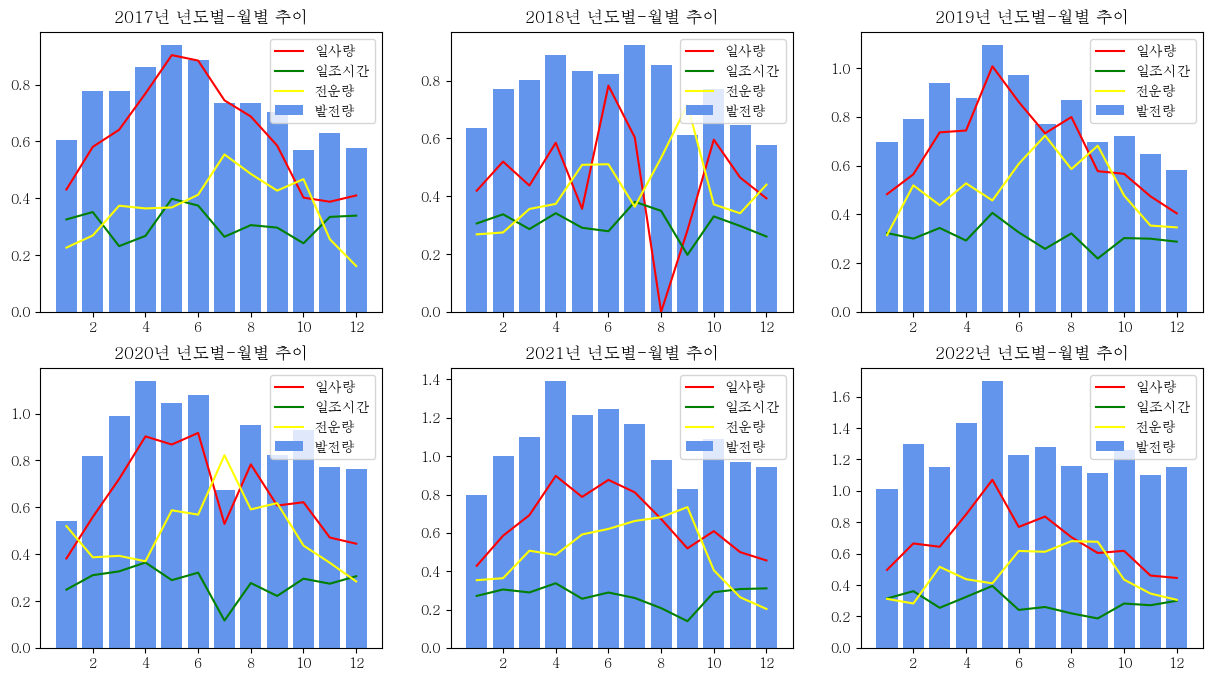

In [220]:
df8 = df
df8 = df8.drop(['지역'], axis=1)


g8 = df8.groupby(['년', '월'])
g8 = g8.mean()

g8.reset_index(inplace=True)

gr8 = g8

years = [2017, 2018, 2019, 2020, 2021, 2022]

def y_filter(year) :
  y_filter = gr8['년'] == year
  return y_filter

fig, axes = plt.subplots(2, 3, figsize=(15,8))

for i in range(6) :
  axes[i//3][i%3].set_title(f"{years[i]}년 년도별-월별 추이")
  axes[i//3][i%3].tick_params(labelsize=10)
  axes[i//3][i%3].bar(gr8['월'].unique(), gr8['발전량'][y_filter(years[i])]/10, color='cornflowerblue')
  axes[i//3][i%3].plot(gr8['월'].unique(), gr8['일사량'][y_filter(years[i])], color='red')
  axes[i//3][i%3].plot(gr8['월'].unique(), gr8['일조시간'][y_filter(years[i])], color='green')
  axes[i//3][i%3].plot(gr8['월'].unique(), gr8['전운량'][y_filter(years[i])]/10, color='yellow')
  axes[i//3][i%3].legend(['일사량','일조시간', '전운량', '발전량'])


# gr8

- 2018년 데이터 중 7월20일 ~ 9월15일 데이터 누락 확인
  -> 해당 월(7,8,9월) 평균값으로 대체 필요

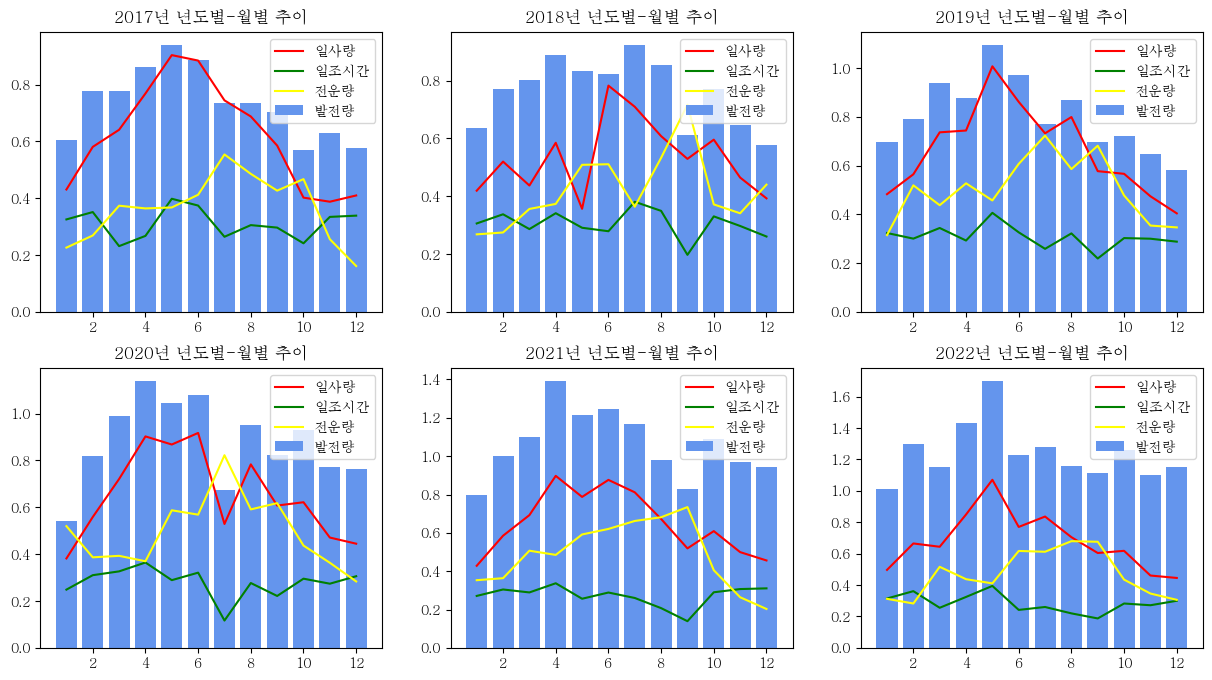

In [221]:
df9 = df
df9 = df9.drop(['지역'], axis=1)


g9 = df9.groupby(['년', '월'])
g9 = g9.mean()

g9.reset_index(inplace=True)

gr9 = g9


# 데이터 누락 부분 평균값 처리 (2018년 7,8,9월)
for i in range(7,10) :
  gr9['일사량'][(gr9['년']==2018) & (gr9['월']==i)] = replace_insolation[i]


years = [2017, 2018, 2019, 2020, 2021, 2022]

def y_filter(year) :
  y_filter = gr9['년'] == year
  return y_filter

fig, axes = plt.subplots(2, 3, figsize=(15,8))

for i in range(6) :
  axes[i//3][i%3].set_title(f"{years[i]}년 년도별-월별 추이")
  axes[i//3][i%3].tick_params(labelsize=10)
  axes[i//3][i%3].bar(gr9['월'].unique(), gr9['발전량'][y_filter(years[i])]/10, color='cornflowerblue')
  axes[i//3][i%3].plot(gr9['월'].unique(), gr9['일사량'][y_filter(years[i])], color='red')
  axes[i//3][i%3].plot(gr9['월'].unique(), gr9['일조시간'][y_filter(years[i])], color='green')
  axes[i//3][i%3].plot(gr9['월'].unique(), gr9['전운량'][y_filter(years[i])]/10, color='yellow')
  axes[i//3][i%3].legend(['일사량','일조시간', '전운량', '발전량'])


# gr8

     3. 월별 합계 발전량, 합계 일조시간, 평균 일사량 추이 분석 (bar, line)
       - 월별 합계 발전량, 합계 일조시간, 평균 일사량, 평균 강수량 추이 분석을 통해 발전 효율이 좋은 월 선정

     -> 발전 효율이 가장 좋은 달 : 5월
     * 월별 발전량, 평균일사량 추이를 봤을 때 봄 중에서도 5월에 발전량이 가장 높게 나오고 있음을 확인 수 있다.
     * 비교 사이트 출처 :https://m.blog.naver.com/haezoom/220614911325

     고찰
     * 통상 봄, 가을에 발전효율이 좋다는 통계를 바탕으로 위 차트를 해석했을 때
     * 봄(3~5), 가을(9~11월) 구간대에서 봄은 통계에 맞게 나오나, 가을의 경우 변별력이 모호한 것을 볼 수 있다.
     * 허나 지역 제한(부산 국한), 모듈의 각도 등이 배제되어 있어 전국 데이터를 활용한다면 보다 통계에 맞는 데이터 추출이 가능할 것으로 보인다.

,계절,년,월,일,시간,발전량,강수량,풍속,풍향,습도,일조시간,일사량,전운량,시정
0,봄,26754336,52992,209808,152352,141062.69,1811.3,46092.8,2346960.0,815611.0,4192.0,10011.72,59377.0,30000504.0
1,여름,26754336,92880,209808,152352,127396.24,4814.8,42301.7,2017960.0,1046186.0,3716.3,9546.35,78281.0,28988217.0
2,가을,26463528,131040,205344,150696,108465.65,2214.9,36889.0,2015300.0,851431.0,3489.8,6810.76,60889.0,38360331.0
3,겨울,26209083,66138,202002,149316,102976.05,656.5,40282.3,2997980.0,603415.0,4000.4,6207.74,41945.0,33965400.0


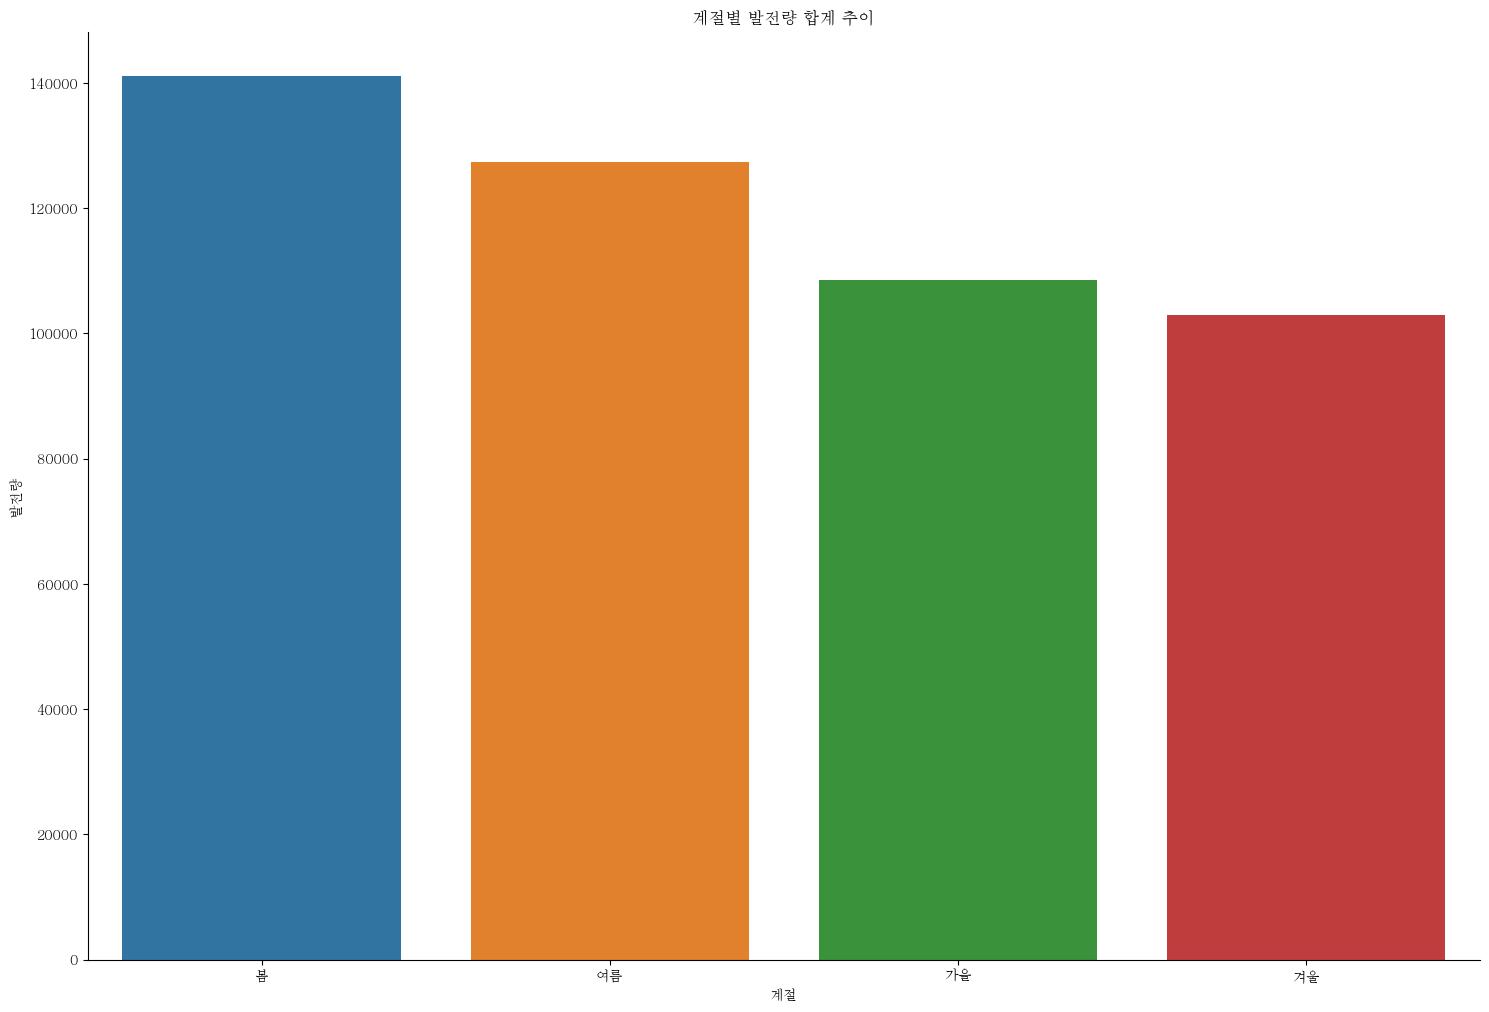

In [222]:
# 계절별 발전량 비교
# 구간 설정 : 봄(3~5), 여름(6~8), 가을(9~11), 겨울(12~2)
df7 = df
df7 = df7.drop(['지역'], axis=1)

filter_spring = df7['월'].isin([3,4,5])
filter_summer = df7['월'].isin([6,7,8])
filter_autumn = df7['월'].isin([9,10,11])
filter_winter = df7['월'].isin([12,1,2])

df7['계절'] = np.NaN
df7['계절'][filter_spring] = '봄'
df7['계절'][filter_summer] = '여름'
df7['계절'][filter_autumn] = '가을'
df7['계절'][filter_winter] = '겨울'


g7 = df7.groupby('계절')
gr7 = g7.sum()

gr7 = gr7.reindex(index=['봄','여름','가을','겨울'])

gr7.reset_index(inplace=True)


sns.catplot(data=gr7, x='계절', y='발전량', kind='bar', height=10, aspect=1.5)
plt.title('계절별 발전량 합계 추이')

gr7

In [256]:
# ANOVA

gr77 = g7.mean()

gr77 = gr77.reindex(index=['봄','여름','가을','겨울'])
gr77.reset_index(inplace=True)

weather_list = ['봄','여름','가을','겨울']
mean_list = []

for i in range(4) :
  x = gr77['발전량'][gr77['계절']==weather_list[i]][i]
  mean_list.append(x)

print(mean_list)

anova_list = []

for w in weather_list :
  anova_list.append(df7['발전량'][df7['계절']==w])

print(stats.f_oneway(*anova_list))

# p-value < 0.05를 만족하므로 귀무가설 기각

[10.647847977053141, 9.616262077294687, 8.277293192918192, 7.934662505779011]
F_onewayResult(statistic=123.97018809406202, pvalue=5.149349173087717e-80)
